# Analysis for PoST Parameters
The proof consists of a single nonce and several "good" labels.

In [1]:
from IPython.display import display,Math,Markdown
from scipy.stats import binom
import math
from math import log, floor, ceil, sqrt

def dm(str):
    display(Markdown(str))


## Honest Parameters

In [2]:
## Global Parameters

n = 2**35 # Total number of labels

honest_opt_error = 2**(-10) # Honest users should fail with at most this probability with {honest_nonces} nonces.
honest_min_error = 2**(-20) # We also compute the number of nonces to achieve this error.

### Hashing-related
label_len = 8 # Label size in bytes (actually a label-block --- that is, the number of bytes of input for a single hash function invocation)
#nonces_per_hash = 128/log(n,2) # Number of nonces per hash invocation (example here is for 34-bit threshold and AES-128).
nonce_output_len = ceil(log(n,2)/8)*8
nonces_per_hash = 128 / nonce_output_len # Ensure output is aligned on byte boundaries
#nonces_per_hash = 2

## Node-specific parameters

hash_labels_per_sec = 2**27 # Number of hash invocations per second. ; this is a "fast" CPU
read_mb_per_sec = 200 # Disk read speed in MB/s ; this is a fast machine
scrypt_per_sec = 2**13

hash_labels_per_sec_slow = 2**26 # Number of hash invocations per second. ; this is a "slow" CPU
read_mb_per_sec_slow = 150 # Disk read speed in MB/s ; this is a slow machine
scrypt_per_sec_slow = 2**11.843


# Maximum expected time for "slow" machines to spend doing rate-limiting PoW (in seconds). [We don't currently use this value]
max_honest_rate_limiting_pow_overhead = 240


## Adversarial Parameters

We use these parameters to compute the minimal number of good labels needed.

In [3]:
# Minimal fraction of data that the adversary stores
#c = 0.80 
c = 0.75 

# Multiplicative advantage for adversary in solving rate-limiting PoW vs CPU-solving honest party
adv_pow_advantage = 1000 # If fastest adversary solves PoW in 1 second, then honest user on CPU takes `adv_pow_advantage` seconds.

adv_init_time = 60*60*24 # Adversarial initialization time (for a single space unit) in seconds

# maximum number of adversarial nonces. Trying this number of nonces should be as expensive as initializing the unstored part of the adversary's claimed space.
adv_nonces = 8e6


In [4]:

# Display the calculations for a proof that requires $k$ good labels out of $n$, where each label is good with probability $p$.
def display_results(k, n, p):
    actualq = binom.sf(k,n,p) # Actual probability of finding at least k good labels out of n (might differ from q due to rounding)
    adv_prob = binom.sf(k, ceil(c*n), p)
    adv_log_prob = binom.logsf(k, ceil(c*n), p)/log(2)

    if actualq == 0 or actualq == 1 or log(1-actualq) == 0:
        dm(rf"**Warning**: actualq=${actualq:.2f}=2^{{ {log(actualq,2):.2f} }}$")
        
    
    opt_nonces = ceil(log(honest_opt_error)/log(1-actualq))
    honest_actual_error = (1-actualq)**opt_nonces
    
    expected_nonces = ceil(1/actualq)
    # expected_batches = ceil(expected_nonces / honest_nonce_batch)

    max_nonces = ceil(log(honest_min_error)/log(1-actualq))

    adv_success_log_prob = binom.logsf(0, adv_nonces, adv_prob)/log(2) # We use the binom.logsf function rather than directly computing because it handles the underflows more nicely.
        
    dm(rf"""### Proof consists of a single nonce with {k} good labels
For honest users: $q=\Pr[Binom(n=2^{{ {log(n,2):.2f} }}, p={p*n:.2f}/n) \ge {k}] = {binom.sf(k,n,p):.2f} = 2^{{ {binom.logsf(k,n,p)/log(2):.2f} }}$
  *  Expected number of nonces for honest parties is {expected_nonces} ({ceil(expected_nonces/nonces_per_hash)} hash invocations per label)
  *  Need {opt_nonces} nonces to ensure honest failure probability of less than $2^{{ {log(honest_actual_error,2):.2f} }} \le 2^{{ {log(honest_opt_error,2):.2f} }}$
  *  Need {max_nonces} nonces to ensure honest failure probability of less than $2^{{ {log(honest_min_error,2):.2f} }}$
  
For the adversary: $\Pr[Binom({c:.2f}\cdot n, p={p*n:.2f}/n) \ge {k}] = {adv_prob:.2f} = 2^{{ {adv_log_prob:.2f} }}$
  *  Expected number of nonces for adversary is ${floor(1/adv_prob)}=2^{{ {-adv_log_prob:.2f} }}$
  *  With $2^{{ {log(adv_nonces,2):.2f} }}$ nonce attempts, probability that adversary succeeds is less than $2^{{ {adv_success_log_prob:.2f} }}$
""")
    

## Inverse calculations and optimizations

### Finding $p$ given $k$ and $q$

In [5]:
from scipy import optimize

k = 2000
q = 0.47

# Find the p that minimizes, for a binomially distributed variable Binom with parameters n,p, the error
# |Pr[Binom(n,p) >= k] - q|. 
def find_p(k2: int, n1: int, q1: float):
    """Find p such that Pr[X \ge k]=q when X~Binom(n,p)"""
    def p_error(k1):
        if k1 <= 0: 
            return math.inf
        actualq = binom.sf(k2,n1,k1/n1)
        if actualq == 0:
            return 3-k1/n1
        elif actualq == 1:
            return 2+k1/n1
        return (q1 - actualq)**2

    bounds=(0, 3*k2)
        
    res = optimize.minimize_scalar(p_error,bounds=bounds, method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
        
    return res.x/n1

p = find_p(k,n,q)

# Finding q given p
def find_q_given_p(k, n, p):
    return binom.sf(k, n, p)

dm(rf"Best solution found is $p=2^{{ {log(p,2):.3f} }} = \frac{{ {p*n:.2f} }} {{ n }}$")
dm(rf"$\Pr[Binom(n=2^{{ {log(n,2):.2f} }}, p={p*n:.2f}/n \ge {k}] = {find_q_given_p(k,n,p):.2f}$")

Best solution found is $p=2^{ -24.036 } = \frac{ 1997.30 } { n }$

$\Pr[Binom(n=2^{ 35.00 }, p=1997.30/n \ge 2000] = 0.47$

### Finding $q$

We're trying to maximize the gap between the honest success probability and the adversarial success. This gap grows with the inverse of $q$, so the optimal $q$ is just bounded by the honest success probability (or, equivalently, by the expected number of nonces the honest parties must try)

In [6]:
# Find q that guarantees honest users will succeed with honest_nonces except with probability honest_opt_error
def find_q(honest_opt_error, honest_nonces):
    return 1-(honest_opt_error)**(1/honest_nonces)


### Optimizing Honest Nonces
Here, we're trying to find the maximum number of nonces that allow honest users on "fast" computers to read at I/O speed.

In [7]:

# Number of nonces that succeed with probability `percentile`
def percentile_honest_nonces(q, percentile):
    if q == 1:
        return 1
    return ceil(log(1-percentile)/log(1-q))

# number of parallel nonces to equalize read time and hashing time (not necessarily an integer)
def break_even_nonces(hash_labels_per_sec, read_labels_per_sec):
    return hash_labels_per_sec / read_labels_per_sec * nonces_per_hash


read_labels_per_sec_fast = read_mb_per_sec * 2**20 / label_len
break_even_fast_nonces = break_even_nonces(hash_labels_per_sec, read_labels_per_sec_fast)

q = find_q(2**(-20), floor(break_even_fast_nonces))

dm(rf"""
* Break-even nonces for fast nodes: {break_even_fast_nonces:.2f} ({break_even_fast_nonces/nonces_per_hash} hash invocations)
* $q={q:.2f}$ for {floor(break_even_fast_nonces)} nonces to succeed except with probability ${honest_opt_error:.3f} = 2^{{ {log(honest_opt_error,2):.2f} }}$
""")



* Break-even nonces for fast nodes: 16.38 (5.12 hash invocations)
* $q=0.58$ for 16 nonces to succeed except with probability $0.001 = 2^{ -10.00 }$


### Optimizing Parallel Nonces for Slower Nodes

In [8]:

# Actual labels-per-second for a given number of parallel nonces (this is either dominated by hash speed or by read speed)
def labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces):
    hashes_per_label = ceil(parallel_nonces/nonces_per_hash) # Have to perform an integer number of hashes
    return min(hash_labels_per_sec / hashes_per_label, read_labels_per_sec)

def expected_total_passes(parallel_nonces, q):
    q1 = 1-(1-q)**parallel_nonces # Probability of success in a single pass.
    return 1/q1

# Number of passes that succeed with probability `percentile`
def percentile_total_passes(parallel_nonces, q, percentile):
    q1 = 1-(1-q)**parallel_nonces # Probability of success in a single pass.
    if q1 == 1:
        return 1
    return ceil(log(1-percentile)/log(1-q1))

def expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q):
    return expected_total_passes(parallel_nonces, q) / labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces)


def percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q, percentile):
    return percentile_total_passes(parallel_nonces, q, percentile) / labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces)


def find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q):
    def exp_time(parallel_nonces):
        return expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, ceil(parallel_nonces), q)+1/(parallel_nonces*2**40)
    
    break_even = break_even_nonces(hash_labels_per_sec, read_labels_per_sec)
    res = optimize.minimize_scalar(exp_time, bounds=(0, 5*ceil(break_even)), method='bounded', options={'xatol': 0.5, 'maxiter': 2000})
    return ceil(res.x)

def time_per_pass(hash_labels_per_sec, read_labels_per_sec, q):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    expected_time_per_label = expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q)
    time_per_pass = expected_time_per_label * n / 60
    return time_per_pass

def percentile_time_per_pass(hash_labels_per_sec, read_labels_per_sec, q, percentile):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    percentile_time_per_label =  percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q, percentile)
    time_per_pass = percentile_time_per_label * n / 60
    return time_per_pass


def display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec, q, n):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    mb_per_sec = read_labels_per_sec * label_len / 2**20
    expected_time_per_label = expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q)
    p99_per_label = percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q, 0.99)
    
    dm(rf"""#### Optimized execution for $q={q:.2f}$, $2^{{ {log(hash_labels_per_sec,2):.2f} }}$ hashes/sec, ${mb_per_sec:.2f}$ MB/sec read rate
* Optimal number of parallel nonces: {parallel_nonces}
  - {ceil(parallel_nonces/nonces_per_hash)} hash invocations
  - will take {expected_total_passes(parallel_nonces,q):.6f} passes in expectation
  - Expected total time per label is {expected_time_per_label:.2e} seconds.
      - 99${{}}^{{th}}$-percentile time per label is {p99_per_label:.2e} seconds
  - Expected total time for $2^{{ {log(n,2):.2f} }}$ labels is ${expected_time_per_label * n / 60:.2f}$ minutes.
      - 99${{}}^{{th}}$-percentile total time is {p99_per_label * n / 60:.2f} minutes
""")

display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec_fast, q, n)

read_labels_per_sec_slow = read_mb_per_sec_slow * 2**20 / label_len
display_optimized_nonces(hash_labels_per_sec_slow, read_labels_per_sec_slow, q, n)

#### Optimized execution for $q=0.58$, $2^{ 27.00 }$ hashes/sec, $200.00$ MB/sec read rate
* Optimal number of parallel nonces: 16
  - 5 hash invocations
  - will take 1.000001 passes in expectation
  - Expected total time per label is 3.81e-08 seconds.
      - 99${}^{th}$-percentile time per label is 3.81e-08 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $21.85$ minutes.
      - 99${}^{th}$-percentile total time is 21.85 minutes


#### Optimized execution for $q=0.58$, $2^{ 26.00 }$ hashes/sec, $150.00$ MB/sec read rate
* Optimal number of parallel nonces: 9
  - 3 hash invocations
  - will take 1.000411 passes in expectation
  - Expected total time per label is 5.09e-08 seconds.
      - 99${}^{th}$-percentile time per label is 5.09e-08 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $29.14$ minutes.
      - 99${}^{th}$-percentile total time is 29.13 minutes


### Optimizing $k$ given $q$

In [9]:
# Find the smallest k that requires the adversary to search through min_adv_nonces in expectation to find a solution.

def find_k(q: float, n1: int, c1: float, min_log_adv_nonces: int):
    def k_error(k):
        k = ceil(k)
        p = find_p(k, n1, q)
        
        adv_log_prob = binom.logsf(k, ceil(c1*n1), p)/log(2)
        expected_log_nonces = -adv_log_prob
        
        if expected_log_nonces < min_log_adv_nonces:
            return math.inf
        else:
            return k
    
    res = optimize.minimize_scalar(k_error, bounds=(16, 1000), method='bounded', options={'xatol': 0.5, 'maxiter': 2000})
    return res.x


# Use q computed above
k = find_k(q, n,c,log(adv_nonces,2))
k = ceil(k)
p = find_p(k,n,q)


display_results(k,n,p)


### Proof consists of a single nonce with 378 good labels
For honest users: $q=\Pr[Binom(n=2^{ 35.00 }, p=382.59/n) \ge 378] = 0.58 = 2^{ -0.79 }$
  *  Expected number of nonces for honest parties is 2 (1 hash invocations per label)
  *  Need 8 nonces to ensure honest failure probability of less than $2^{ -10.00 } \le 2^{ -10.00 }$
  *  Need 16 nonces to ensure honest failure probability of less than $2^{ -20.00 }$
  
For the adversary: $\Pr[Binom(0.75\cdot n, p=382.59/n) \ge 378] = 0.00 = 2^{ -22.95 }$
  *  Expected number of nonces for adversary is $8086676=2^{ 22.95 }$
  *  With $2^{ 22.93 }$ nonce attempts, probability that adversary succeeds is less than $2^{ -0.67 }$


## Optimizing $q$ given $k$ and `min_adv_nonces`

Here, we want to fix $k$ and find the largest value of $q$ for which the adversary still requires `min_adv_nonces` in expectation.

In [10]:
def find_p_given_k(k: int, n1: int, c1: float, min_log_adv_nonces: int):
    def p_error(k1):
        p = k1/n1
        
        if p == 0:
            return math.inf
        
        adv_log_prob = binom.logsf(k, ceil(c1*n1), p)/log(2)
        expected_log_nonces = -adv_log_prob
        
        if expected_log_nonces < min_log_adv_nonces:
            return k1
        else:
            return -k1
    
    res = optimize.minimize_scalar(p_error, bounds=(0, 5*k), method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
    if not res.success:
        dm("**Warning**: `find_p_given_k` optimization unsuccessful!")
    return res.x / n


k=170
p = find_p_given_k(k, n, c, log(adv_nonces,2))
q = find_q_given_p(k, n, p)

display_results(k,n,p)
display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec_fast, q, n)
display_optimized_nonces(hash_labels_per_sec_slow, read_labels_per_sec_slow, q, n)

### Proof consists of a single nonce with 170 good labels
For honest users: $q=\Pr[Binom(n=2^{ 35.00 }, p=149.14/n) \ge 170] = 0.04 = 2^{ -4.56 }$
  *  Expected number of nonces for honest parties is 24 (8 hash invocations per label)
  *  Need 160 nonces to ensure honest failure probability of less than $2^{ -10.02 } \le 2^{ -10.00 }$
  *  Need 320 nonces to ensure honest failure probability of less than $2^{ -20.00 }$
  
For the adversary: $\Pr[Binom(0.75\cdot n, p=149.14/n) \ge 170] = 0.00 = 2^{ -22.93 }$
  *  Expected number of nonces for adversary is $8000005=2^{ 22.93 }$
  *  With $2^{ 22.93 }$ nonce attempts, probability that adversary succeeds is less than $2^{ -0.66 }$


#### Optimized execution for $q=0.04$, $2^{ 27.00 }$ hashes/sec, $200.00$ MB/sec read rate
* Optimal number of parallel nonces: 19
  - 6 hash invocations
  - will take 1.781001 passes in expectation
  - Expected total time per label is 7.96e-08 seconds.
      - 99${}^{th}$-percentile time per label is 2.68e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $45.59$ minutes.
      - 99${}^{th}$-percentile total time is 153.60 minutes


#### Optimized execution for $q=0.04$, $2^{ 26.00 }$ hashes/sec, $150.00$ MB/sec read rate
* Optimal number of parallel nonces: 19
  - 6 hash invocations
  - will take 1.781001 passes in expectation
  - Expected total time per label is 1.59e-07 seconds.
      - 99${}^{th}$-percentile time per label is 5.36e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $91.19$ minutes.
      - 99${}^{th}$-percentile total time is 307.20 minutes


## Computing Rate-limiting PoW difficulty and time

In [11]:
# Total time that all the rate-limiting PoWs together should take for the adversary (in seconds)
adv_total_rate_limiting_pow_time = adv_init_time * (1-c)

honest_pow_time_per_nonce = adv_total_rate_limiting_pow_time * adv_pow_advantage / adv_nonces
total_expected_honest_pow_time = honest_pow_time_per_nonce / q


dm(rf"""
* Total PoW time for adversary: {adv_total_rate_limiting_pow_time / (60*60):.2f} hours
   - Per-nonce$\times$space-unit difficulty for adversary should be {adv_total_rate_limiting_pow_time / adv_nonces:.3f} seconds
   - This means each nonce-block$\times$space-unit PoW should have difficulty {nonces_per_hash*adv_total_rate_limiting_pow_time / adv_nonces:.3f} seconds
* Total expected PoW time for honest party: {total_expected_honest_pow_time:.2f} seconds
   - Expected per-nonce$\times$space-unit PoW time for honest party: {honest_pow_time_per_nonce:.2f} seconds (each per-nonce PoW should be a $2^{{ {log((1-c)/adv_nonces,2):.2f} }}$ fraction of the total number of PoST init hashes).
* Total 99${{}}^{{th}}$-percentile PoW time for honest party: {percentile_honest_nonces(q, .99)*honest_pow_time_per_nonce:.2f} seconds
""")


* Total PoW time for adversary: 6.00 hours
   - Per-nonce$\times$space-unit difficulty for adversary should be 0.003 seconds
   - This means each nonce-block$\times$space-unit PoW should have difficulty 0.009 seconds
* Total expected PoW time for honest party: 63.59 seconds
   - Expected per-nonce$\times$space-unit PoW time for honest party: 2.70 seconds (each per-nonce PoW should be a $2^{ -24.93 }$ fraction of the total number of PoST init hashes).
* Total 99${}^{th}$-percentile PoW time for honest party: 288.90 seconds


# Nice graphs

In [12]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

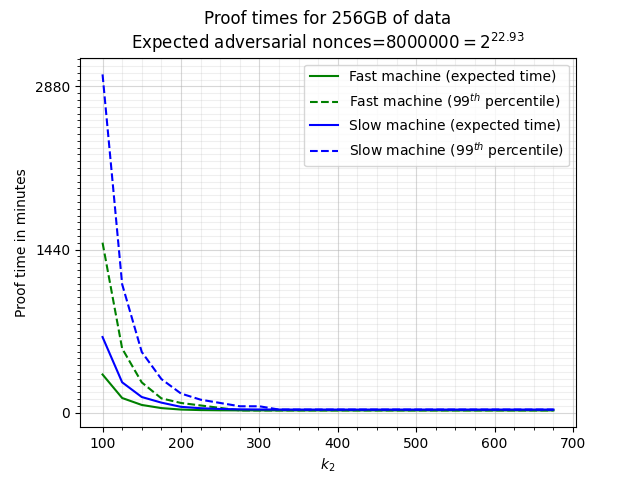

(Major grid lines on y axis are days, minor grid lines are hours)

In [13]:
from_k,to_k,step_k = 100, 700, 25

k_arr = np.arange(from_k, to_k, step_k)
p_vals = { k: find_p_given_k(k, n, c, log(adv_nonces,2)) for k in k_arr }
q_vals = { k: find_q_given_p(k, n, p_vals[k]) for k in k_arr }



fig, ax = plt.subplots()

ax.plot(k_arr, [time_per_pass(hash_labels_per_sec,read_labels_per_sec_fast, q_vals[k]) for k in k_arr], 'g-', label="Fast machine (expected time)")
ax.plot(k_arr, [percentile_time_per_pass(hash_labels_per_sec,read_labels_per_sec_fast, q_vals[k],0.99) for k in k_arr], 'g--', label="Fast machine ($99^{th}$ percentile)")
ax.plot(k_arr, [time_per_pass(hash_labels_per_sec_slow,read_labels_per_sec_slow, q_vals[k]) for k in k_arr], 'b-', label="Slow machine (expected time)")
ax.plot(k_arr, [percentile_time_per_pass(hash_labels_per_sec_slow,read_labels_per_sec_slow, q_vals[k],0.99) for k in k_arr], 'b--', label="Slow machine ($99^{th}$ percentile)")



ax.set_xticks(k_arr, minor=True)
ymin,ymax = ax.get_ylim()
ax.set_yticks(np.arange(0, ymax, 60*24))
ax.set_yticks(np.arange(0, ymax, 60), minor=True)
ax.grid(axis='both', which='major', alpha=0.5)
ax.grid(axis='both', which='minor', alpha=0.2)

plt.title(rf"Proof times for {n*label_len/2**30:.0f}GB of data" + "\n" + rf"Expected adversarial nonces=${adv_nonces:.0f}=2^{{ {log(adv_nonces,2):.2f} }}$")
plt.xlabel('$k_2$')
plt.ylabel('Proof time in minutes')
plt.legend(loc="upper right")

plt.show()
dm("(Major grid lines on y axis are days, minor grid lines are hours)")